In [2]:
#imports 
import numpy as np
import pandas as pd
from scipy.special import factorial
import matplotlib.pyplot as plt
from pathlib import Path
# plt.rcParams["figure.figsize"] = (20,20)
# plt.rcParams["font.size"] = 20

from ase.io import gen, vasp, xyz
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview

_ColormakerRegistry()

In [2]:
data = pd.read_csv("../cleanjerkdata.csv", index_col=0)
data = data.iloc[:, 0]
data = data.str.split(r'\s+x')
data

Column 1
110      [55, 0.5]
120     [63, 0.52]
130     [70, 0.54]
140     [78, 0.56]
150     [85, 0.57]
160     [92, 0.58]
170     [99, 0.58]
180    [106, 0.59]
190    [113, 0.59]
200     [119, 0.6]
210     [126, 0.6]
220     [132, 0.6]
230     [138, 0.6]
240     [144, 0.6]
250     [150, 0.6]
260     [156, 0.6]
270     [161, 0.6]
280     [167, 0.6]
290    [172, 0.59]
300    [177, 0.59]
310    [183, 0.59]
110      [55, 0.5]
120     [63, 0.52]
130     [70, 0.54]
140     [78, 0.56]
150     [85, 0.57]
160     [92, 0.58]
170     [99, 0.58]
180    [106, 0.59]
190    [113, 0.59]
200     [119, 0.6]
210     [126, 0.6]
220     [132, 0.6]
230     [138, 0.6]
240     [144, 0.6]
250     [150, 0.6]
260     [156, 0.6]
270     [161, 0.6]
280     [167, 0.6]
290    [172, 0.59]
300    [177, 0.59]
310    [183, 0.59]
Name: Column 2, dtype: object

Text(0.5, 0, 'bodyweight (lbs)')

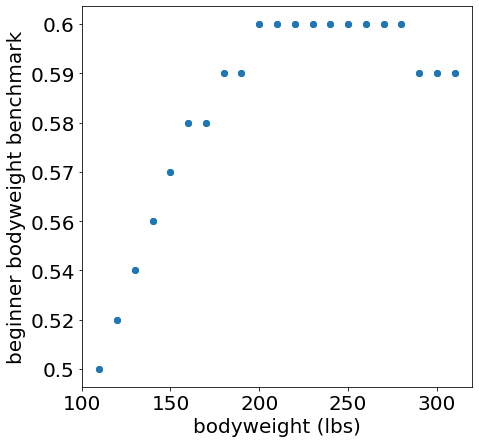

In [3]:
plt.figure(figsize = (7,7))
plt.scatter(data.index, [i[1] for i in data], marker = 'o')
plt.ylabel("beginner bodyweight benchmark")
plt.xlabel("bodyweight (lbs)")

## Physical constants

In [4]:
kb = 8.617e-5 #eV/K
T = 80 + 273 #80 C -> K
h = 4.136e-15 #eV*s
m = 5.7e-26 #mass of MeF, kg
Na = 6.022e23 #avagadro's number
R = 8.617e-5 #eV/K (molecular gas constant)

# ASE

In [5]:
struct = [i for i in xyz.read_xyz("../TRAJEC.xyz", index = 0)][0]
boxlen = 11.29

struct.set_cell([boxlen] * 3)


vasp.write_vasp("POSCAR_vc", struct, vasp5= True)

In [6]:
#to visualize input.gen
view(gen.read_gen("../input.gen"))

In [7]:
struct = gen.read_gen("../geom.out" + ".gen")

#construct 
xmult, ymult, zmult = 2, 2, 1
P = np.array([[xmult, 0, 0], 
          [0, ymult, 0], 
          [0, 0, zmult]]).reshape(3,-1)
supercell = make_supercell(struct, P)
# view(supercell, viewer = "x3d")

np.random.seed(429)
a, b, c, alpha, beta, gamma = supercell.get_cell_lengths_and_angles()
supercell_cell = supercell.get_cell()

results_dir_name = "temp"
results_dir = Path(results_dir_name)
results_dir.mkdir(parents=True, exist_ok=True)

In [8]:
view(supercell)
gen.write_gen("2x2input.gen", supercell)

In [9]:
np.random.seed(429)
for i in range(25):
    del supercell[[atom.index for atom in supercell if atom.symbol == 'Ar']]
    x_rand, y_rand, z_rand = supercell_cell.cartesian_positions(np.random.random(size = 3))
    add_adsorbate(supercell, adsorbate = 'Ar', height = 7, position = (x_rand, y_rand))
    filename = "output" + str(i) + ".gen"
    filepath = results_dir / filename
    
    with filepath.open("w") as f: 
        gen.write_gen(f, supercell) #write gen file
        
#         fig, ax = plt.subplots()
#         plot_atoms(supercell, ax)
#         fig.savefig("output")


view(supercell)
# view(supercell, viewer = "x3d")

In [10]:
from ase.geometry.analysis import Analysis
from ase.neighborlist import natural_cutoffs

default_cutoffs = natural_cutoffs(struct, bothways= True)
my_cutoffs = default_cutoffs

for i in range(len(my_cutoffs)):
    if default_cutoffs[i] == 1.11: #Si
        my_cutoffs[i] = 1.2
    elif default_cutoffs[i] == 0.71: #N
        my_cutoffs[i] = 0.74
    elif default_cutoffs[i] == 0.31: #H
        my_cutoffs[i] = 0.46
    elif default_cutoffs[i] == 0.57: #C
        my_cutoffs[i] = 0.77


anal = Analysis(struct, cutoffs = default_cutoffs)
# # anal.get_angles("N", "Si", "N")
# for i in range(len(struct)):
# #     print(struct[i])
#     print(np.sum(anal.adjacency_matrix[0][i,:].todense()), ":", struct[i])
numpoints = 120
plt.plot(np.linspace(0, 6.77/2, numpoints), anal.get_rdf(6.77/2, numpoints)[0])

KeyboardInterrupt: 

In [ ]:
sin_bonds = anal.get_bonds("Si","N")[0]
counts = dict()
for bond in sin_bonds:
    i, j = bond
    counts[i] = counts.get(i, 0) + 1
    counts[j] = counts.get(j, 0) + 1
counts

## HCl adsorbate

In [ ]:
# print(sirich)
from ase import Atoms
d = 1.27
i = 1
for x in np.arange(0, 1, .2):
    for y in np.arange(0, 1, .2):
        sirich = vasp.read_vasp("../CONTCAR")
        x, y, z = sirich.cell.cartesian_positions([x, y, 0])
        hcl = Atoms('HCl', positions=[(x, y, 0), (x, y + d, 0)])
        add_adsorbate(sirich, adsorbate = hcl, height = 2, position = (x, y))
#         view(sirich)
        vasp.write_vasp("../POSCAR" + str(i), sirich, vasp5=True)
        i += 1

# Water box generation

Wolfram alpha query:
https://www.wolframalpha.com/input/?i=%287.666+angstroms%29+*+%2822.981+angstroms%29+*+%285.85+angstroms%29+*+1+gram%2Fcm%5E3+*+%2818+g%2Fmol%29%5E%28-1%29+*+N_A


For the box 

    22.980921000000000  000000000000000000  000000000000000000
    -3.8301539999999998    6.6340209999999997    0.0000000000000000
    000000000000000000  000000000000000000  5.8501700000000000

the above query tells us we need 34.48 -> 34 water molecules

In [ ]:
#generation parameters
n = 34 #number of waters
num_per_layer = 2
correction = 1 # set to 1 if you miss a layer; otherwise, 0

#reference water location
initial_O = np.array([0.01, 0.01, 0.01]) 
initial_H1 = np.array([0.01, 0.01, 0.18]) 
initial_H2 = np.array([0.01, 0.14, 0.01]) 

#initialize ouptut lists
O_output = np.array([])
H_output = np.array([])

#reference to a vector
lowerlim = 0.16
upperlim = 0.60 
vacuum_height = 1 - (upperlim - lowerlim)

#set spacings
a_space = vacuum_height/(n / num_per_layer) #assume even n and 2 waters per layer
b_space = 1/2 
c_space = 1/4 

for i in np.arange(int(1/a_space) + correction):
    for j in np.arange(num_per_layer):
        #offsets a and c locations in step, b location within the layer
        if i * a_space < lowerlim or i * a_space > upperlim:
            O_output = np.append(O_output, np.array(initial_O + np.array([i * a_space, j * b_space + i*c_space, i*c_space])))
            O_output = np.append(O_output, np.array(["  T"]*3 ))
            H_output = np.append(H_output, np.array(initial_H1 + np.array([i * a_space, j * b_space+ i*c_space, i*c_space])))
            H_output = np.append(H_output, np.array(["  T"]*3 ))
            H_output = np.append(H_output, np.array(initial_H2 + np.array([i * a_space, j * b_space+ i*c_space, i*c_space])))
            H_output = np.append(H_output, np.array(["  T"]*3 ))
O_output = O_output.reshape(-1, 6)
H_output = H_output.reshape(-1, 6)

In [ ]:
np.array(O_output, dtype = str).shape

In [ ]:
np.savetxt("../o_test.txt", O_output, fmt = "%s")

In [ ]:
np.savetxt("../h_test.txt", H_output, fmt = "%s")

#  Sticking probability calculation

Forward rate constant from physisorbed to chemisorbed state: 
$$
    k_A = \frac{k_B T}{h}\exp{\left(\Delta S^{\ddagger}/R\right)} \exp{\left(-E_A/RT\right)}
$$

Backwards rate constant, desorption:
$$
k_D = \left(
            \frac{k_BT}{2\pi m}
      \right)^{1/2}
      \exp\left(\Delta S/R \right)
      \exp\left(-E_D/RT\right)
$$

By Vineyard (eq 23),
$$
\Delta S^\ddagger = k_B\ln\left(\frac{\prod v_i^0}{\prod v_i'}\right) = k_B\left(\sum \ln v_i^0 - \sum \ln v_i' \right) 
$$

We approximate these values by taking the ratio of the sum of the normal modes of the system, i.e., the eigenvalues of each state's dynamical matrix:

$$
    k_A = \frac{k_B T}{h}\frac{\sum_{TS}\lambda_i}{\sum_{init}\lambda_i}\exp{\left(-E_A/RT\right)}
$$


$$
k_D = \left(
            \frac{k_BT}{2\pi m}
      \right)^{1/2}
      \exp\left(\Delta S_{literature}/R\right)
      \exp\left(-E_D/RT\right)
$$

Then, these figures can be used to calculate the sticking probabiility as 
$$
    p = \frac{k_A}{k_A + k_D}
$$

In [ ]:
from eigenval_analyze import eigenval_analyze
unit = "THz"
initial_eigenvals = eigenval_analyze("../OUTCAR_init", unit)
ts_eigenvals = eigenval_analyze("../OUTCAR_ts", unit )
S_adsorb = kb * np.log(np.prod(initial_eigenvals)/np.prod(ts_eigenvals))
S_adsorb

In [ ]:
kb*T/h

In [ ]:
k_A =  np.exp(-0.96/(R * T))
print("k_A is", k_A)

Entropy of a diatomic ideal gas: https://www.usna.edu/Users/physics/mungan/_files/documents/Scholarship/ClassicalIdealGas.pdf

They assume that the potential and kinetic vibrational degrees of freedom are "frozen out": this is okay for us, because these degrees of freedom should basically factor out in the sticking probability calculation.
If anything, this will overestimate the sticking probability, since $k_D(no~vib. DoF) < k_D(vib. DoF)$

$$
\begin{align*}
    S &= Nk\left[
        7/2 + \ln \frac{V(2\pi mkT)^{5/2}4\pi I/m}
        {Nh^5}
    \right]\\
    &= Nk\left[
        7/2 + \ln \frac{kT(2\pi mkT)^{5/2}4\pi I/m}  
        {p\cdot h^5}
    \right]& \left(\text{since } \frac{N}{V} = \frac{p}{kT}\right) \\
    &= Nk\left[
        7/2 + \ln \frac{kT(2\pi mkT)^{5/2}4\pi \left(1/4 r^2 \right)}   
        {p\cdot h^5}
    \right]& \left(I = 1/4 mr^2 \right)\\
    &= Nk\left[
        7/2 + \ln \frac{kT(2\pi mkT)^{5/2}\pi r^2 }   
        {p\cdot h^5}
    \right]& \left(I = 1/4 mr^2 \right)
\end{align*}
$$

In [ ]:
N = 1 #number of molecules considered
r = 1.35e-10 # C-F bond length, meters
p = .004 #kPa

S_desorb_total = N*kb * (
    7/2 + np.log(
            (kb * T * (2 * np.pi * m * kb * T)**(5/2) * np.pi * r**2)/
            (p * h**5)
    )
) # J/K to eV/K

S_desorb_translational = N*kb * (
    5/2 + np.log(
            (kb * T * (2 * np.pi * m * kb * T)**(3/2) * np.pi * r**2)/
            (p * h**3)
    )
) # J/K to eV/K


S_desorb_total

In [ ]:
k_D = np.exp(-0.21/(R*T))
print("k_D is ", k_D) 

In [ ]:
eb = -0.48
np.exp(eb/(R*T))/(np.exp(eb/(R*T)) + np.exp(-.21/(R*T)))

# Green-Kubo/VACF

Read data, find split between vacf and fft data, apply split, give column names

In [ ]:
vacf_data = pd.read_csv("../vacf_hf", delim_whitespace=True)
split_idx = vacf_data.loc[vacf_data["0"] == 0, :].index[0]
vacf_fft = vacf_data[split_idx:].reset_index(drop = True)
vacf_data = vacf_data[:split_idx]
vacf_data.columns = ["Time (fs)", "Value"]
vacf_fft.columns = ["Wavenumber", "Value"]
vacf_data

In [ ]:
vacf_fft

In [ ]:
vacf_data.plot("Time (fs)", "Value");
vacf_fft.plot("Wavenumber", "Value");

Green-Kubo relation for determining coefficient of diffusion:

# Kinetic energy of ion 

In [ ]:
v = 0.15
6240000000000000000 * 0.5 * 1.66E-27*39.95*(v*100000)**2

# NELECT calculator

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def calc_nelect(Si, N, H, C, F, Ar, charge):    
    return Si*4 + N*5 + H*1 + C*4 + F*7 + Ar*8 - charge 

interact(calc_nelect,
         Si = widgets.IntText(value = 0),
         N = widgets.IntText(value = 0),
         H = widgets.IntText(value = 0),
         C = widgets.IntText(value = 0),
         F = widgets.IntText(value = 0),
         Ar = widgets.IntText(value = 0),
         charge = widgets.IntText(value = 0)
        );

# Energy analysis 

In [ ]:
from energyanimator import *
energies = oszicarSearch("../OSZICAR", "E0")

In [ ]:
plt.plot(np.arange(len(energies)), energies)
plt.xlabel("timestep (fs)")
plt.ylabel("Internal energy, E0 (eV)");

In [ ]:
plt.plot(np.arange(len(energies)), oszicarSearch("../OSZICAR", "E"))
plt.xlabel("timestep (fs)")
plt.ylabel("Free energy, E (eV)");

In [ ]:
plt.plot(np.arange(len(energies)), oszicarSearch("../OSZICAR", "EK"))
plt.xlabel("timestep (fs)")
plt.ylabel("Kinetic Energy, EK (eV)");

# 2D collision Monte Carlo


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation director.
animation = FuncAnimation(fig, update, interval=10)
plt.show()

# Birthday simulation 

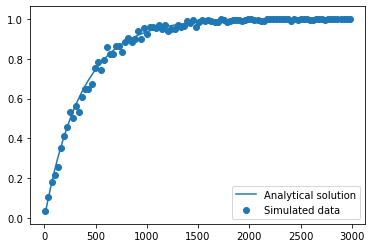

In [3]:
sample = np.arange(10, 3000, 30)
num_reps = 500
prop_birthday_array = np.array([])
for num_followers in sample:
    birthdays = np.random.randint(365, size = num_followers)
    birthday_today_sum = 0
    for i in range(num_reps): #1000 replications per given follower count    
        random_today = np.random.randint(365)
        birthday_today_sum += random_today in birthdays #check if any birthdays are "today"
    prop_birthday_array = np.append(prop_birthday_array, birthday_today_sum/num_reps)
plt.scatter(sample, prop_birthday_array);
plt.plot(sample, 1 - (364/365)**sample);
plt.legend(["Analytical solution", "Simulated data"]);

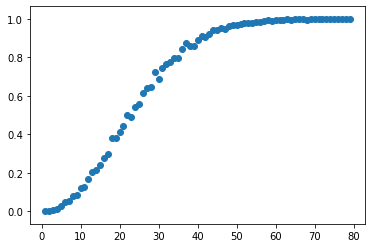

In [4]:
sample = np.arange(1, 80)
num_reps = 1000
prop_birthday_array = np.array([])
for num_people in sample:
    birthday_match_sum = 0 
    for i in range(num_reps):
        birthdays = np.random.randint(365, size = num_people) #simulate birthdays of random group
        birthday_match_sum += len(set(birthdays)) != len(birthdays)
    prop_birthday_array = np.append(prop_birthday_array, birthday_match_sum/num_reps)
plt.scatter(sample, prop_birthday_array);

In [13]:
np.arange(10, 0, -1)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

# Decomposition threshold calculation/visualization

In [ ]:
#list format: [highest nondecomp velo, lowest decomp velo]
v_ch3f = np.array([.05, .075])
v_ch2f2 = np.array([.1, .103])
v_chf3 = np.array([.09, .1])
v_cf4 = np.array([.08, .09])

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6240000000000000000 * 0.5 * 1.66E-27*39.95*(v_tot*100000)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6240000000000000000 * 0.5 * 1.66E-27*39.95))/100000

Ed_ch3f = KE(v_ch3f)
Ed_ch2f2 = KE(v_ch2f2)
Ed_chf3 = KE(v_chf3)
Ed_cf4 = KE(v_cf4)

plt.figure(figsize=(3, 6))
Ed = np.vstack((Ed_ch3f, Ed_ch2f2, Ed_chf3, Ed_cf4))
xrange = range(1, 5)
plt.vlines(xrange, Ed[:, 0], Ed[:, 1], linewidth = 3)
plt.xticks(ticks = xrange, labels = ["CH3F", "CH2F2", "CHF3", "CF4"])
plt.ylabel("Dissociation energy threshold (eV)")
plt.grid(axis = 'x')

In [ ]:
v_from_KE(np.arange(Ed_ch3f[0], Ed_ch2f2[1], .5))

In [ ]:
(29.2392359999999982 * (0.7299277018045487 - 0.5319035085506911))/(v_from_KE(np.arange(*Ed_cf4, step = .5)))

# Rotating molecules

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
#cartesian coordinates
c = np.array([-0.07080961517377,   4.39791093730960,   15.55245221574159])
f1 = np.array([-1.29252093562230,   4.38985564638638,   15.86091698258102])
f2 = np.array([0.46655734032090,   3.27409499032153,   16.05264845711701])
f3 = np.array([0.45543942453280,   5.52631694772198,   16.05346389416853])
f4 = np.array([-0.03996298251498,   4.40464583205707,   14.20939151614791])

cf4 = np.vstack((c, f1, f2, f3, f4))
cf4_xs, cf4_ys, cf4_zs = np.split(cf4, 3, axis = 1)

ax.set_xlim(min(cf4_xs), max(cf4_xs))
ax.set_ylim(min(cf4_ys), max(cf4_ys))
ax.set_zlim(min(cf4_zs), max(cf4_zs))
ax.scatter(cf4_xs, cf4_ys, cf4_zs, s = 500)

Rotation matrix: https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations

In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('zyx', [90, 0, 0], degrees=True)

r_cf4 = np.vstack([r.apply(i) for i in cf4])


fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

r_cf4_xs, r_cf4_ys, r_cf4_zs = np.split(r_cf4, 3, axis = 1)

ax.set_xlim(min(r_cf4_xs), max(r_cf4_xs))
ax.set_ylim(min(r_cf4_ys), max(r_cf4_ys))
ax.set_zlim(min(r_cf4_zs), max(r_cf4_zs))
ax.scatter(r_cf4_xs, r_cf4_ys, r_cf4_zs, s = 500)

In [ ]:
from scipy.stats import maxwell
x = np.linspace(0, 4, 100)
plt.plot(x, maxwell.pdf(x));

# Energy calculations 

In [ ]:
no_vdw_adsorbed = -.56052502E+03
vdw_adsorbed = -.57382237E+03
no_vdw_slab = -.53641007E+03
vdw_slab = -.54946959E+03
no_vdw_ch3f = -.24118519E+02
vdw_ch3f = -.24155344E+02

In [ ]:
no_vdw_adsorbed - (no_vdw_slab + no_vdw_ch3f)

In [ ]:
vdw_adsorbed - (vdw_ch3f + vdw_slab)

In [ ]:
unit_cell_product = -.57381823E+03
unit_cell_product - (vdw_ch3f + vdw_slab)


# OSZICAR plotting

Distances

In [ ]:
dist = pd.read_csv("9-16ArNdist.dat", sep = "\s+", header = None, index_col = 0)

In [ ]:
dist.plot()

In [ ]:
from energyanimator import oszicarSearch
# energies = oszicarSearch("../OSZICAR")
energies = pd.read_csv("energies", header = None).iloc[:, 0]
energies = energies - energies[0]
plt.plot(np.arange(len(energies)), energies)
plt.ylabel("relative potential energy")
plt.xlabel("time (fs)");

In [ ]:
kinetic = pd.read_csv("kinetic", header = None).iloc[:, 0]
kinetic = kinetic - kinetic[0]
plt.plot(np.arange(len(kinetic)), kinetic)
plt.ylabel("relative kinetic energy")
plt.xlabel("time (fs)");

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s = slice(50, -1)
x = dist.index[s]/2
y1 = dist.iloc[s, 0]
y2 = energies[s]
y3 = kinetic[s]
y4 = y2 + y3

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-', label = 'potential E')
ax2.plot(x, y3, 'r-', label = 'kinetic E')
ax2.plot(x, y4, 'c-', label = 'total E')

ax1.set_xlabel('time (fs)')
ax1.set_ylabel('Ar-N distance (Å)', color='g')
ax2.set_ylabel('Relative energy (eV)', color='b')
ax1.set_title("Distance vs E")
ax1.set_ylim(0, 10)
plt.legend()
plt.show()

In [ ]:
dDiffs = np.diff(y1)
plt.plot(x[:-1], dDiffs)
plt.xlabel("time (fs)")

In [ ]:
plt.figure(figsize = (10, 4))
lpdata = pd.read_csv("../energies.normal.silane", header = None)
sidedata = pd.read_csv("../energies.dangle.silane", header = None)
distances = np.arange(4, 0, -.05)
mask = distances >= 1.5
plt.plot(distances[mask], lpdata.iloc[:, 0][mask], label = "normal silane")
plt.legend()
plt.show()
plt.figure(figsize = (10, 4))
plt.plot(distances[mask], sidedata.iloc[:, 0][mask], label = "silane with DB");
plt.legend();
# plt.ylim(-100, 100)

# Energy diagram


## For full MeF decomp process

In [ ]:
import matplotlib.pyplot as plt
from energydiagram import ED
diagram = ED(linewidth = 1)
diagram.add_level(0, top_text = '')
diagram.add_level(-0.2,top_text='')
diagram.add_level(.77,top_text='')
diagram.add_level(-.08,top_text='')
diagram.add_level(-.94,top_text='')
diagram.add_link(0, 1)
diagram.add_link(1, 2)
diagram.add_link(2, 3)
diagram.add_link(3, 4)

fig, ax = diagram.plot()
plt.savefig('temp.png',dpi = 300)

## For comparison of dangling bond sites

In [ ]:
from energydiagram import ED
plt.figure(figsize = (10,10))
diagram = ED()

E = -np.round(-532.5637 - np.array([-.53286625E+03, -.53292514E+03, -.53256365E+03, -532.7026]), decimals = 4)
diagram.add_level(E[0],'config 1')
diagram.add_level(E[1],'config 2', position = 'last')
diagram.add_level(E[2],'config 3', position = 'last')
diagram.add_level(E[3],'config 4', position = 'last')

diagram.plot()

## For physisorption of MeF

In [ ]:
from energydiagram import ED


plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'axes.labelsize': 22})

diagram = ED()

e1 = -0.2
e2 = 0
e3 = -0.23
e4 = -0.18
e5 = -0.18

diagram.add_level(e1,'1 MeF \n adsorbed')
diagram.add_level(e2)
diagram.add_level(e3,'3 MeF \n adsorbed')
diagram.add_level(e4,'4 MeF \n adsorbed')
diagram.add_level(e5,'5 MeF \n adsorbed')


# diagram.add_link(0, 1)
diagram.add_link(2, 3)
diagram.add_link(3, 4)
# diagram.add_link(4, 5)

diagram.plot()


In [ ]:
from energydiagram import ED


plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'axes.labelsize': 22})

diagram = ED()

e1 = -0.2
e2 = 0
e3 = round(-0.23*3, 2)
e4 = -0.18*4
e5 = round(-0.18*5, 2)

diagram.add_level(e1,'1 MeF \n adsorbed')
diagram.add_level(e2)
diagram.add_level(e3,'3 MeF \n adsorbed')
diagram.add_level(e4,'4 MeF \n adsorbed')
diagram.add_level(e5,'5 MeF \n adsorbed')


# diagram.add_link(0, 1)
diagram.add_link(2, 3)
diagram.add_link(3, 4)
# diagram.add_link(4, 5)

diagram.plot()


# Distance plots (vmd output)

In [ ]:
filename = "../NHdist-nonSCC.dat"
data = pd.read_csv(filename, header = None, sep = "\t")
lefttime, righttime = 0, np.inf
timeslice = np.logical_and(np.array(data[0]) < righttime, lefttime < np.array(data[0]))
plt.plot(data[0][timeslice], data[1][timeslice])
plt.title(filename)
plt.xlabel('time (fs)')
plt.ylabel("distance (Å)");

# Deepchem :0 

Tutorials here https://github.com/deepchem/deepchem/tree/master/examples/tutorials

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import deepchem as dc

# Configurational entropy

In [ ]:
free = lambda N: N * (N-1) * (N-2)/factorial(3)
cluster = lambda N: N* (N-1)/2

In [ ]:
x = np.arange(50)
plt.plot(x, (free(x) - cluster(x)));

In [ ]:
(free(x) - cluster(x))